In [2]:
import pandas as pd
import numpy as np
import re
from scipy import stats
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
from itertools import combinations


from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import shapely, geopandas, fiona 
import geopandas as gpd
import descartes
from shapely.geometry import Polygon, Point, MultiPolygon

from matplotlib.path import Path

In [3]:
#load the data frame
DF = pd.read_csv('Data/food-inspections.csv', sep = ',')
DF = DF.drop_duplicates()
df_in = DF.copy()

In [93]:
# drop columns with null values
DF = DF.dropna(subset = ['Violations','Facility Type','Risk','Longitude','Latitude','Zip','AKA Name'])
print(len(DF))

#give new indices to each remaining column
DF.index = range(1,len(DF) + 1)

141909


In [94]:
#obtain year, month and day from date
DF['year'] = DF['Inspection Date'].apply(lambda x:x.split('-')[0])
DF['month'] = DF['Inspection Date'].apply(lambda x:x.split('-')[1])
DF['day'] = DF['Inspection Date'].apply(lambda x:x.split('-')[2])
DF['day'] = DF['day'].apply(lambda x:x.split('T')[0])
DF.head(5)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,year,month,day,Violation_num
1,2345318,SUBWAY,SUBWAY,2529116.0,Restaurant,Risk 1 (High),2620 N NARRAGANSETT AVE,CHICAGO,IL,60639.0,...,"{'latitude': '-87.78575236468352', 'longitude'...",NaN,NaN,NaN,NaN,NaN,2019,11,08,None
2,2345334,LA MICHOACANA ICE CREAM SHOP,LA MICHOACANA ICE CREAM SHOP,2698396.0,Restaurant,Risk 1 (High),3591-3597 N MILWAUKEE AVE,CHICAGO,IL,60641.0,...,"{'latitude': '-87.73518301995274', 'longitude'...",NaN,NaN,NaN,NaN,NaN,2019,11,08,None
3,2345339,THE CREPE SHOP,THE CREPE SHOP,2699005.0,Restaurant,Risk 1 (High),2934 N BROADWAY,CHICAGO,IL,60657.0,...,"{'latitude': '-87.64440716256712', 'longitude'...",NaN,NaN,NaN,NaN,NaN,2019,11,08,None
4,2345319,GOPUFF,GOPUFF,2684558.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,60613.0,...,"{'latitude': '-87.6743946694658', 'longitude':...",NaN,NaN,NaN,NaN,NaN,2019,11,08,None
5,2345217,"LUNA PARK, INC.",LUNA PARK DAY CARE,2215485.0,Children's Services Facility,Risk 1 (High),3250 W FOSTER AVE,CHICAGO,IL,60625.0,...,"{'latitude': '-87.7107455232781', 'longitude':...",NaN,NaN,NaN,NaN,NaN,2019,11,07,None


## Violation parsing

In [6]:
from itertools import combinations

In [7]:
df_vio = df_in.dropna(subset=['Risk'])
df_vio = df_vio[df_vio['Risk'] != 'All']

In [8]:
def Find_vionumber(vio):
    vionum = []
    if pd.isna(vio) == False:
        for i in vio.split(' | '):
            n = re.findall('([0-9]+)',i[0:4])
            vionum = list(set(vionum).union(set(n)))
    return vionum

In [12]:
def expand_varible(vio):
    var = np.zeros(64)
    if vio !=[]:
        for i in vio:
            n = int(i)-1
            if n == 69:
                n = 63
            var[n] = 1
    return var

In [9]:
#extract the numbering of violations
df_vio['Violation_num'] = df_vio['Violations'].apply(lambda x :Find_vionumber(x))


In [10]:
#get the over all violation list
violation_list = []
for i in df_vio["Violation_num"]:
    violation_list = list(set(violation_list).union(set(i)))
violation_list.sort()

In [13]:

df_vio['Violation_vector'] = df_vio['Violation_num'].apply(lambda x:expand_varible(x))

In [14]:
vio_adj = np.zeros([len(violation_list),len(violation_list)])
for i in df_vio['Violation_num']:
    if i != []:
        
        for j in combinations(i, 2):
            m = int(j[0])-1
            n = int(j[1])-1
            if m == 69:
                m = 63
            if n == 69:
                n = 63
            vio_adj[m][n] = vio_adj[m][n]+1
        for d in i:
            d = int(d)-1
            if d == 69:
                d = 63
            vio_adj[d][d] = vio_adj[d][d]+1
            
            

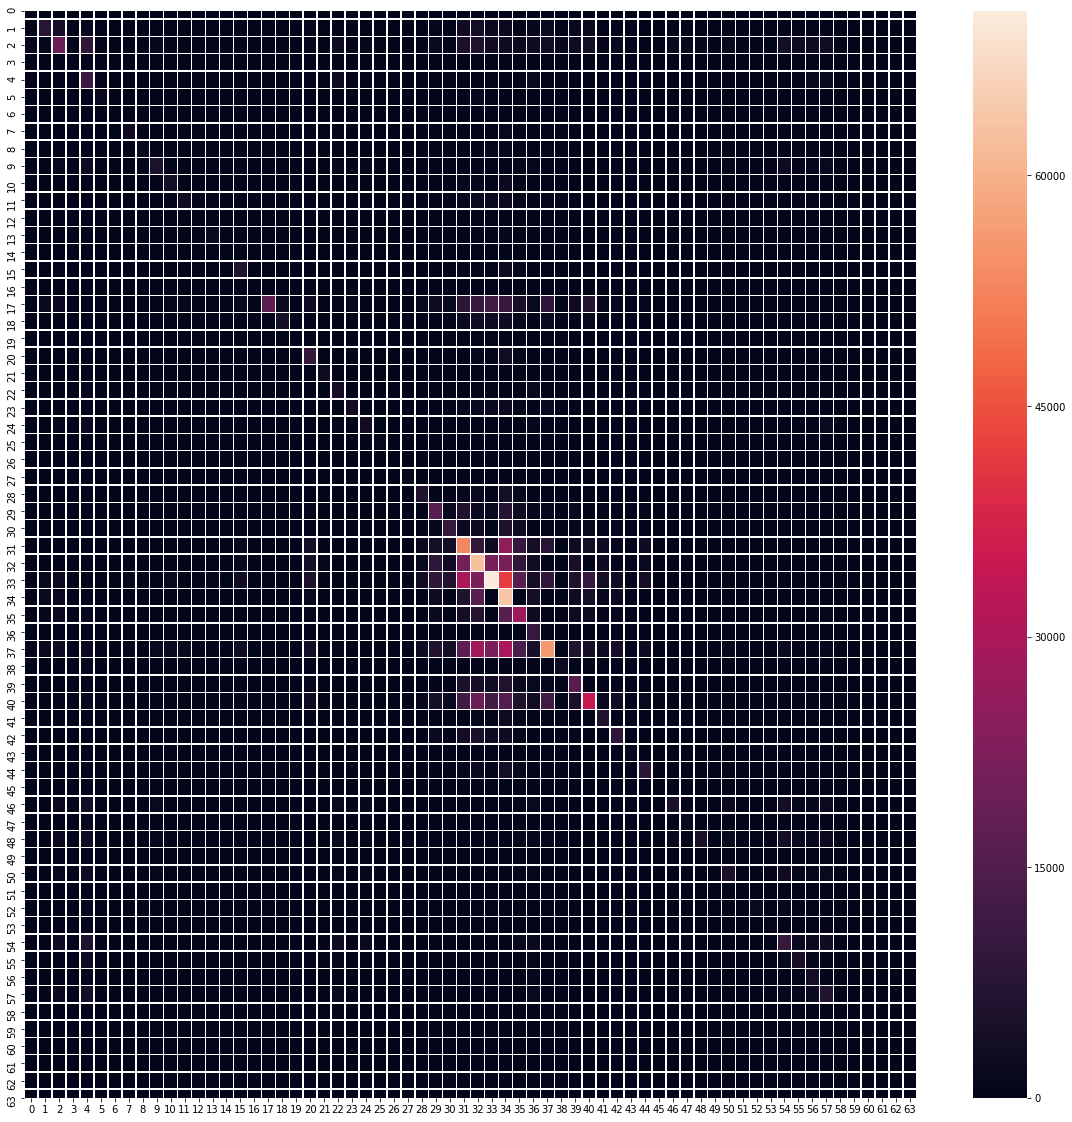

In [17]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(vio_adj, linewidths=.5, ax=ax)

In [22]:
vio_matrix = np.reshape(np.concatenate((df_vio['Violation_vector'].values),axis = 0),(df_vio.shape[0],len(violation_list)))

In [23]:
# compute the correlation between violations to extract the most related violations
corr_vio = np.corrcoef(vio_matrix.T)

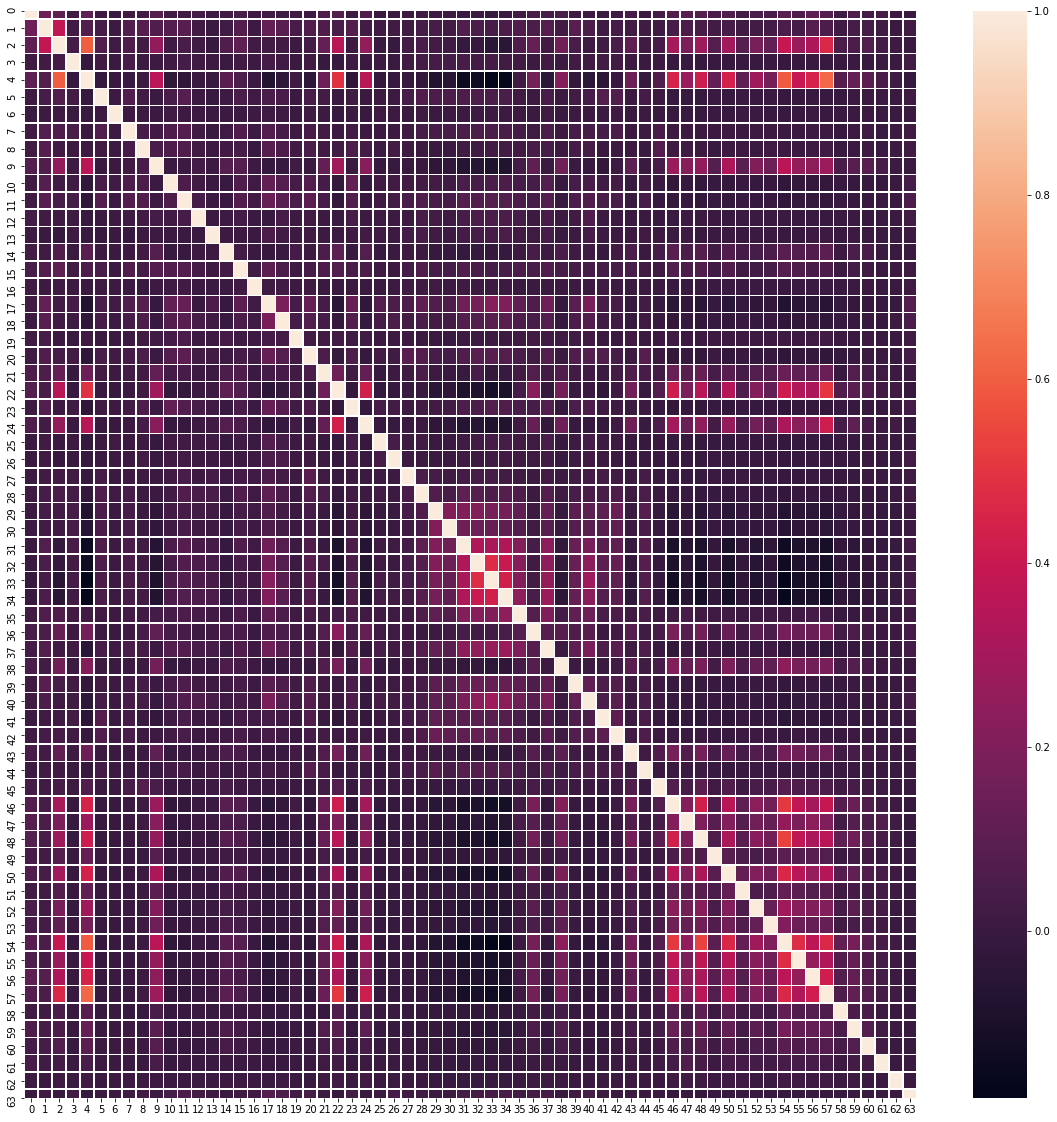

In [24]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(corr_vio,linewidths=.5, ax=ax)

##### input importance analysis

consider violation as the input we want to find out which violations are the most inportant violations

In [25]:
import sklearn
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split

In [26]:
risk_labels = df_vio['Risk'].apply(lambda x:x[5]) 


In [27]:
risk_labels = risk_labels.values

In [28]:
import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# depart the trainning set and test set
X_train, X_test, Y_train, Y_test = train_test_split(vio_matrix, risk_labels, test_size=0.1, random_state=0)


# train the model
logreg = linear_model.LogisticRegression(C=1000)
logreg.fit(X_train, Y_train)

# # predict 
# prepro = logreg.predict_proba(X_test)
# acc = logreg.score(X_test,Y_test)

D:\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
logreg.coef_ #not sure how to use it

array([[-1.28544321e-01, -2.09929908e-01,  5.21003433e-01,
         2.43249806e-01, -1.02725477e+00,  2.21045499e-01,
        -1.31600800e-01,  9.21676242e-01, -4.25176236e-01,
        -3.76967098e-02, -2.04454163e-01, -1.32028807e-01,
        -3.72935581e-01,  6.32498650e-02,  1.30244797e+00,
         2.88825173e-01,  3.41985830e-01, -3.31198281e-01,
        -2.57104137e-01, -8.44240663e-01, -4.24414864e-01,
         2.96162247e-02,  1.07210082e+00, -1.43927955e-01,
         1.51883106e+00,  5.10735725e-03,  1.50253763e-01,
        -3.89752822e-01,  4.91048736e-01,  7.45555162e-01,
         8.68036115e-01,  3.44663350e-01,  1.75587173e-01,
        -2.41320843e-02,  2.28211700e-01,  4.65780608e-02,
        -3.89354509e-01,  2.00915608e-01,  2.32818050e-01,
        -7.88574254e-02, -2.10437826e-01,  1.22158001e-02,
         3.91903596e-01,  4.89585975e-01,  2.97411255e-01,
        -6.64031594e-01,  2.49083291e-01, -1.32270366e-01,
        -4.65610439e-02, -6.66239812e-01,  1.88846721e-0

### Using Random Forest to find out the importance

In [31]:
# from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
x = vio_matrix
y = risk_labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
feat_labels = list(range(1,65))
forest = RandomForestClassifier(n_estimators=100,oob_score=True, random_state=0 , n_jobs=-1)
forest.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [32]:
importances = forest.feature_importances_
importances
# indices = np.argsort(importances)[::-1]
# for f in range(x_train.shape[1]):
#     print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

array([0.00844625, 0.0272609 , 0.02458559, 0.00433167, 0.01090402,
       0.01109812, 0.00213915, 0.0123186 , 0.01392155, 0.01546458,
       0.02181237, 0.02005639, 0.00625435, 0.01108161, 0.00039389,
       0.02606252, 0.00136533, 0.03330601, 0.02241084, 0.00261718,
       0.02648689, 0.01272728, 0.0086383 , 0.02024967, 0.00931106,
       0.01195442, 0.00463436, 0.01328757, 0.02108338, 0.02923737,
       0.02198914, 0.03669134, 0.03943715, 0.03664654, 0.03894437,
       0.04219516, 0.02952454, 0.04466409, 0.0097562 , 0.03968849,
       0.03954341, 0.02109308, 0.02029433, 0.00598296, 0.02302225,
       0.00032925, 0.00832269, 0.00514656, 0.00727993, 0.00236624,
       0.00918568, 0.00237659, 0.00620219, 0.00397602, 0.01034907,
       0.00750288, 0.00780985, 0.03173767, 0.00175195, 0.00274134,
       0.00197503, 0.00016941, 0.0001148 , 0.00774857])

## Inspections number counted by year, month, result, facility type and inspection type

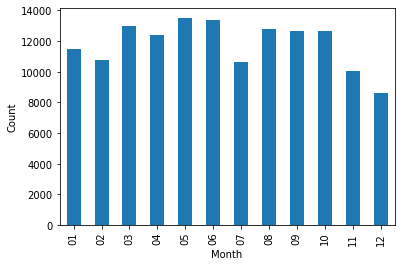

In [95]:
#numbers of inspections by month
mcounts = DF.month.value_counts()
mcounts = mcounts.sort_index()
plt.xlabel('Month');plt.ylabel('Count')
mcounts.plot.bar()

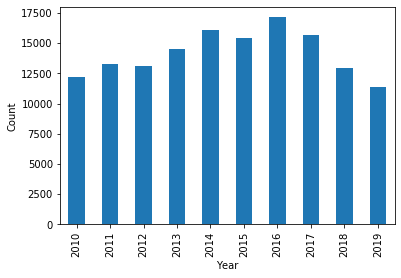

In [96]:
#numbers of inspections by year
ycounts = DF.year.value_counts()
ycounts = ycounts.sort_index()
plt.xlabel('Year');plt.ylabel('Count')
ycounts.plot.bar()

<BarContainer object of 3 artists>

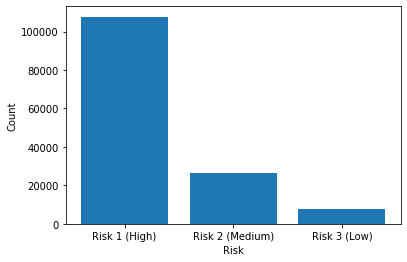

In [97]:
#numbers of inspections by risk
risk = DF.Risk.value_counts().index
rcounts = DF.Risk.value_counts()
plt.xlabel('Risk');plt.ylabel('Count')
plt.bar(risk,rcounts)

([<matplotlib.patches.Wedge at 0x175034ae2c8>,
 [Text(-0.7999651738761493, 0.7550203444843737, 'Risk 1 (High)'),
  Text(0.66342139948008, -0.8774235275577538, 'Risk 2 (Medium)'),
  Text(1.0847151025054809, -0.18273791723811528, 'Risk 3 (Low)')])

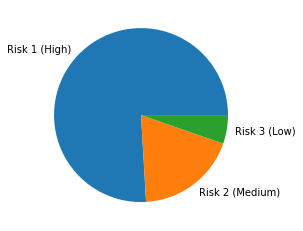

In [98]:
plt.pie(x = rcounts,labels = risk)

Restaurant                      97938
Grocery Store                   17651
School                          10349
Children's Services Facility     2350
Bakery                           2163
Name: Facility Type, dtype: int64


<BarContainer object of 6 artists>

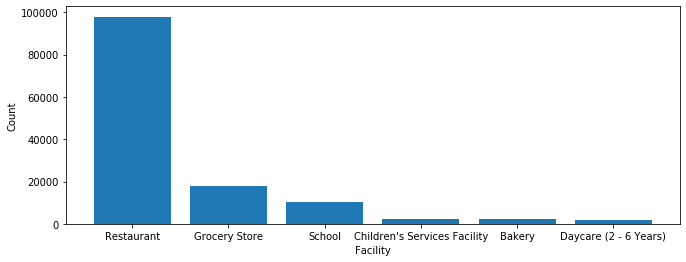

In [99]:
#numbers of inspections by facility
facility = DF['Facility Type'].value_counts().index
fcounts = DF['Facility Type'].value_counts()
print(fcounts.head())

fig = plt.figure(figsize=(11,4))
plt.xlabel('Facility');plt.ylabel('Count')
plt.bar(facility[0:6],fcounts.head(6))

([<matplotlib.patches.Wedge at 0x17503555b48>,
 [Text(-0.7118528945782329, 0.8386092394438494, 'Restaurant'),
  Text(0.26873413421955883, -1.0666686294746202, 'Grocery Store'),
  Text(0.8596765051887602, -0.6862625637658226, 'School'),
  Text(1.0220380960184783, -0.40674086380264757, "Children's Services Facility"),
  Text(1.0589836033332096, -0.29757978404355934, 'Bakery'),
  Text(1.0820961931223974, -0.19765583429288236, 'Daycare (2 - 6 Years)'),
  Text(1.0949923496293101, -0.10484156739234174, 'Daycare Above and Under 2 Years'),
  Text(1.099609712189886, -0.029299843987228246, 'Long Term Care')])

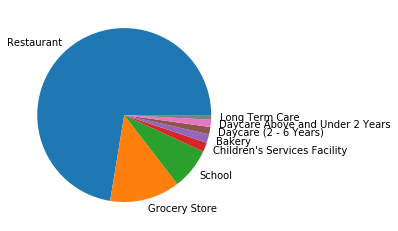

In [100]:
plt.pie(x = fcounts.head(8),labels = facility[0:8])

<BarContainer object of 6 artists>

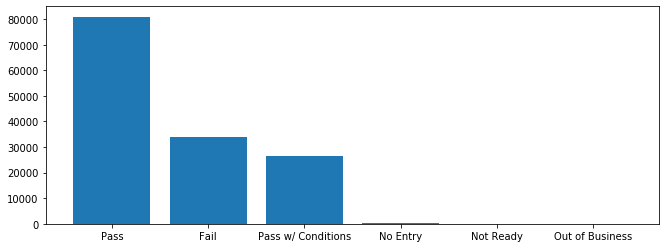

In [101]:
#numbers of inspections by results
result = DF['Results'].value_counts().index
rscounts = DF['Results'].value_counts()
fig = plt.figure(figsize=(11,4))
plt.bar(result,rscounts)

Canvass                     78326
Complaint                   16869
License                     15328
Canvass Re-Inspection       14780
Complaint Re-Inspection      5326
Short Form Complaint         4870
License Re-Inspection        3644
Suspected Food Poisoning      815
Name: Inspection Type, dtype: int64


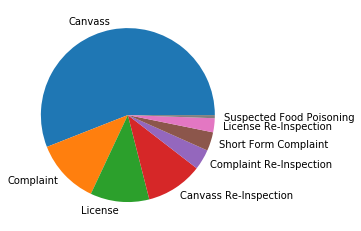

In [102]:
#numbers of inspections by inspection types
inspect_type = DF['Inspection Type'].value_counts().index
ins_counts = DF['Inspection Type'].value_counts()
plt.pie(x = ins_counts.head(8),labels = inspect_type[0:8])
print(ins_counts.head(8))

## Results, Inspection Types and Risks by year&month

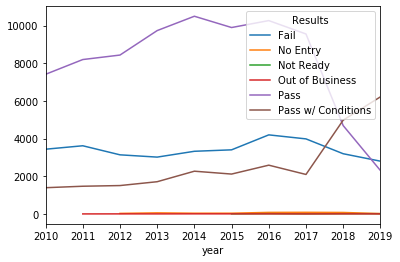

In [103]:
#numbers of each risk in each year
DF_yearisk = DF.groupby(['year','Results'])['Inspection ID'].agg('count').unstack('Results')
DF_yearisk.plot()

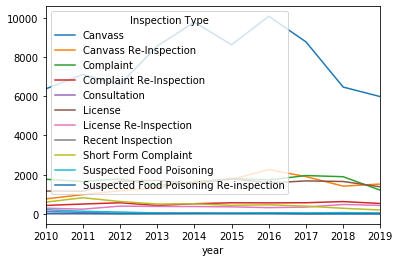

In [104]:
DF_Ins_count = DF.groupby(['year','Inspection Type'])['Inspection ID'].agg('count').unstack('Inspection Type')
DF_Ins_count_new = DF_Ins_count.dropna(axis=1,how='any')
DF_Ins_count_new.plot()

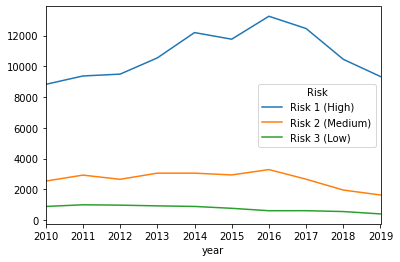

In [105]:
#numbers of each risk in each year
DF_yearisk = DF.groupby(['year','Risk'])['Inspection ID'].agg('count').unstack('Risk')
DF_yearisk.plot()

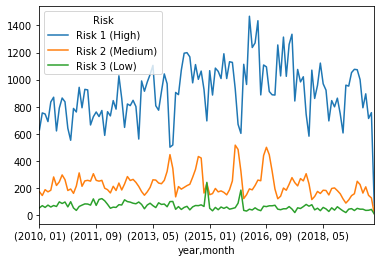

In [106]:
DF_risk = DF.groupby(['year','month','Risk'])['Inspection ID'].agg('count').unstack('Risk')
DF_risk.plot()

Risk,Risk 1 (High),Risk 2 (Medium),Risk 3 (Low)
month,,,
01,9538,1419,525
02,8740,1572,441
03,10463,1977,534
04,10017,1828,532
05,10676,2203,629
06,10513,2314,538
07,7907,2163,576
08,9413,2647,711
09,9193,2861,630


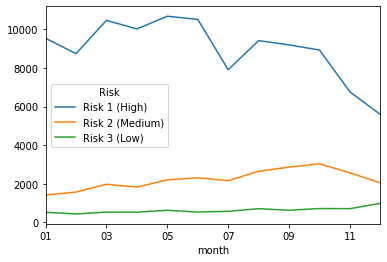

In [107]:
DF_monthrisk = DF.groupby(['month','Risk'])['Inspection ID'].agg('count').unstack('Risk')
DF_monthrisk.plot()
DF_monthrisk

## P-value test of risks of each month

In [108]:
DF_monthrisk['result_vector'] = None 
for i in range(12):
    DF_monthrisk['result_vector'][i] = np.concatenate((np.ones(DF_monthrisk['Risk 1 (High)'][i]), \
                                                       2*np.ones(DF_monthrisk['Risk 2 (Medium)'][i]), \
                                                       3*np.ones(DF_monthrisk['Risk 3 (Low)'][i])),axis = 0)

D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [109]:
shang = np.concatenate((DF_monthrisk['result_vector'][0:6].values),axis = 0)
xia = np.concatenate((DF_monthrisk['result_vector'][6:12].values),axis = 0)

In [110]:
m_count = np.zeros((12,3),dtype=np.int)
for i in range(0,12):
    for j in range(0,3):
        m_count[i][j] = DF_monthrisk.iat[i,j]

f,p = stats.f_oneway(DF_monthrisk['result_vector'][3],DF_monthrisk['result_vector'][11])
print('f=',f,'p=',p)

f= 783.4473181216187 p= 2.725082430426594e-169


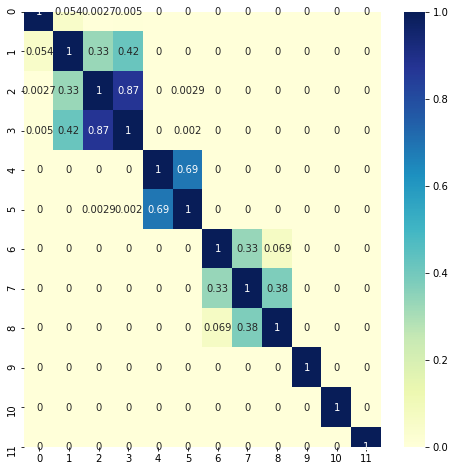

In [111]:
monthrisk_p = [[0]*12 for i in range(12)]
for i in range(0,12):
    for j in range(0,12):
        f,p = stats.f_oneway(DF_monthrisk['result_vector'][i],DF_monthrisk['result_vector'][j])
        if np.isnan(p):
            p = 1.0
        if p < 0.001:
            p = 0
        monthrisk_p[i][j] = p

fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(monthrisk_p, cmap = 'YlGnBu', annot = True)

## Geographical Distribution of Risks and Results 

In [112]:
df_in = pd.read_csv('Data/food-inspections.csv')
df_in = df_in.drop_duplicates()
df_geo = df_in.dropna(subset=['Latitude','Longitude'])
# dist = gpd.read_file('Neighborhoods_2012/neighbors_shp.shp')

In [113]:
dist = gpd.read_file('Neighborhoods_2012/neighbors_shp.shp')

In [114]:
df_geo['cor'] = list(zip(df_geo.Longitude,df_geo.Latitude))
df_geo['cor']= df_geo['cor'].apply(Point)
gdf_geo = gpd.GeoDataFrame(df_geo,geometry = 'cor')

D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [115]:
geo_withdist = geopandas.sjoin(gdf_geo, dist, how="inner", op='intersects')


D:\anaconda3\envs\ada\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [116]:
df_geo = pd.DataFrame(geo_withdist)
df_geo.to_csv("with_district.csv")

In [117]:
from fiona.crs import from_epsg,from_string

In [118]:
#Drop The Date 
gdf_new = geo_withdist.copy()
gdf_new.isnull().sum()

Inspection ID                      0
DBA Name                           0
AKA Name                        2437
License #                         17
Facility Type                   4721
Risk                              70
Address                            0
City                             115
State                             42
Zip                               47
Inspection Date                    0
Inspection Type                    1
Results                            0
Violations                     51179
Latitude                           0
Longitude                          0
Location                           0
Historical Wards 2003-2015    192006
Zip Codes                     192006
Community Areas               192006
Census Tracts                 192006
Wards                         192006
cor                                0
index_right                        0
PRI_NEIGH                          0
SEC_NEIGH                          0
SHAPE_AREA                         0
S

In [119]:
gdf_new['License #'].value_counts()

0.0          500
1354323.0    197
14616.0      176
1574001.0     83
1974745.0     59
            ... 
2009245.0      1
10477.0        1
5652.0         1
2398427.0      1
2326982.0      1
Name: License #, Length: 36793, dtype: int64

In [120]:
#remove all the wrong License information
gdf_new = gdf_new[gdf_new['License #'] != 0.0]
gdf_new['License #'].value_counts()

1354323.0    197
14616.0      176
1574001.0     83
1974745.0     59
1142451.0     49
            ... 
1799001.0      1
1274708.0      1
2549392.0      1
2549389.0      1
2326982.0      1
Name: License #, Length: 36792, dtype: int64

In [121]:
gdf_new.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Location', 'Historical Wards 2003-2015', 'Zip Codes',
       'Community Areas', 'Census Tracts', 'Wards', 'cor', 'index_right',
       'PRI_NEIGH', 'SEC_NEIGH', 'SHAPE_AREA', 'SHAPE_LEN'],
      dtype='object')

In [122]:
# only remain the newest inspction risk result
gdf_new.sort_values(by='Inspection Date',ascending = False, inplace=True)
gdf_new = gdf_new.groupby(['License #']).head(1)# only take the newest facility inspection risk evaluation
# gdf_new = gpd.GeoDataFrame(gdf_new,columns=['Risk','cor','License #', 'Facility Type','Violations','PRI_NEIGH', 'SEC_NEIGH'])
# gdf_new= gpd.GeoDataFrame(gdf_new,geometry = 'cor')

In [123]:
# Geo_dist =dist 
# Geo_dist = pd.merge(Geo_dist,pd.DataFrame(geo_new.groupby(['PRI_NEIGH'])['Risk'].value_counts()).unstack().reset_index())
gdf_new.crs = {'init':'epsg:4326'}
dist.crs = {'init':'epsg:4326'}

In [124]:
gdf_risk3 = gdf_new[gdf_new['Risk'] == 'Risk 3 (Low)'   ]
gdf_risk2 = gdf_new[gdf_new['Risk'] == 'Risk 2 (Medium)']
gdf_risk1 = gdf_new[gdf_new['Risk'] == 'Risk 1 (High)'  ]

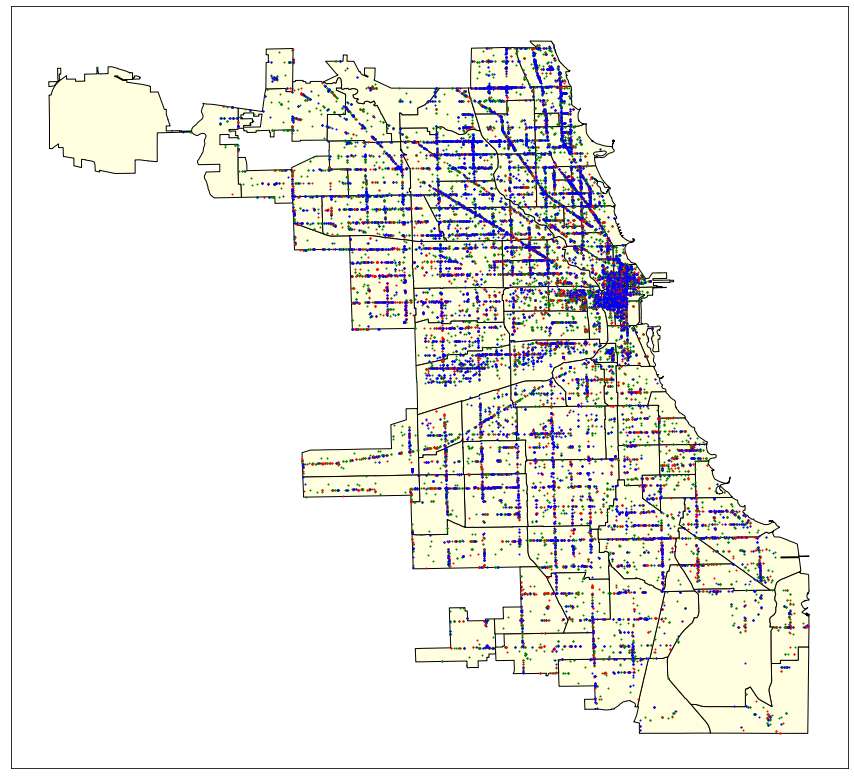

In [125]:
base = dist.plot(color='lightyellow',edgecolor='black',figsize=(15, 15)) #画底图
gdf_risk1.plot(ax=base,marker='o', color='green', markersize=1)
gdf_risk2.plot(ax=base,marker='o', color='red', markersize=1) #在底图上叠加餐厅点数据
gdf_risk3.plot(ax=base,marker='o', color='blue', markersize=1) #在底图上叠加餐厅点数据

plt.gca().xaxis.set_major_locator(plt.NullLocator())#去掉x轴刻度
plt.gca().yaxis.set_major_locator(plt.NullLocator())#去掉y轴刻度



In [126]:
def wgs84_to_CGCS2000(df,code):
    result = df.to_crs(from_epsg(code))
    return result

gdf_new_pcs = wgs84_to_CGCS2000(gdf_new,3435)
risk1_pcs = wgs84_to_CGCS2000(gdf_risk1,3435)
risk2_pcs = wgs84_to_CGCS2000(gdf_risk2,3435)
risk3_pcs = wgs84_to_CGCS2000(gdf_risk3,3435)
dist_pcs = wgs84_to_CGCS2000(dist,3435)

In [127]:
gdf_risk1_buffer = risk1_pcs.buffer(400) 
gdf_risk2_buffer = risk2_pcs.buffer(400) 
gdf_risk3_buffer = risk3_pcs.buffer(400) 

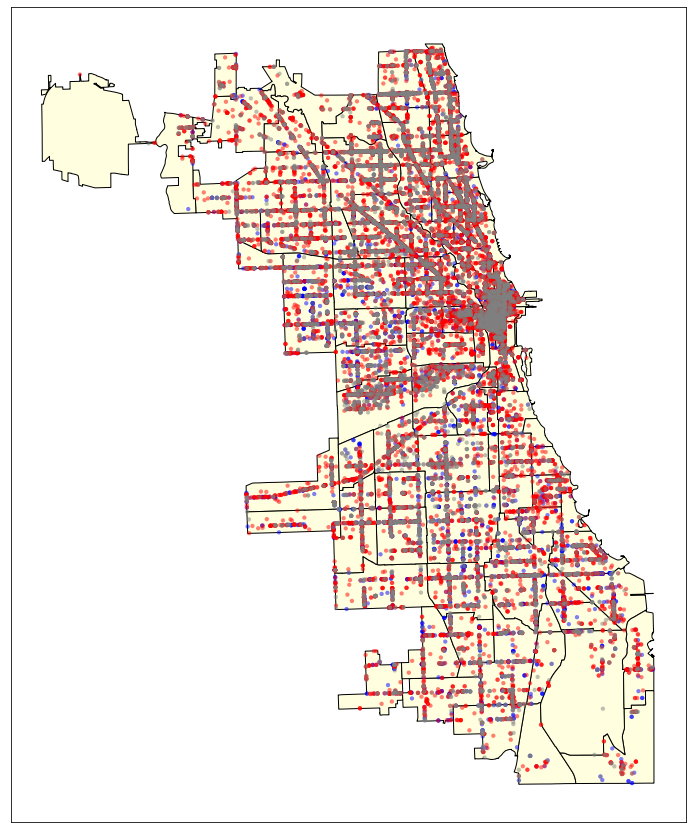

In [128]:

# Geo_in_1_buffer[0]
base = dist_pcs.plot(color='lightyellow',edgecolor='black',figsize=(15, 15))
gdf_risk2_buffer.plot(ax=base,color='blue', markersize=5,alpha=0.5)
gdf_risk1_buffer.plot(ax=base,color='red', markersize=5,alpha=0.5)
gdf_risk3_buffer.plot(ax=base,color='grey', markersize=5,alpha=0.5)
plt.gca().xaxis.set_major_locator(plt.NullLocator()) #去掉x轴刻度
plt.gca().yaxis.set_major_locator(plt.NullLocator()) #去年y轴刻度
# plt.savefig('./map2.png',dpi=400) #保存图片

In [129]:
gdf_new[gdf_new['Risk'] == 'Risk 3 (Low)'   ]['PRI_NEIGH'].value_counts()

Loop              443
Lake View         363
Albany Park       289
Little Village    285
Austin            259
                 ... 
Museum Campus       4
Millenium Park      1
Oakland             1
Grant Park          1
Jackson Park        1
Name: PRI_NEIGH, Length: 97, dtype: int64

In [130]:
dist

,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geometry
0,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
1,Printers Row,PRINTERS ROW,2.162138e+06,6864.247156,"POLYGON ((-87.62761 41.87437, -87.62760 41.873..."
2,United Center,UNITED CENTER,3.252051e+07,23101.363745,"POLYGON ((-87.66707 41.88885, -87.66707 41.888..."
3,Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745,"POLYGON ((-87.65833 41.92166, -87.65835 41.922..."
4,Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351,"POLYGON ((-87.74060 41.88782, -87.74060 41.887..."
...,...,...,...,...,...
93,Ukrainian Village,UKRAINIAN VILLAGE AND EAST VILLAGE,1.062239e+07,13311.469796,"POLYGON ((-87.67705 41.89591, -87.67748 41.895..."
94,Old Town,OLD TOWN,1.984800e+07,17905.728676,"POLYGON ((-87.63612 41.91847, -87.63569 41.917..."
95,Gold Coast,GOLD COAST,7.165706e+06,13685.479377,"POLYGON ((-87.62646 41.91147, -87.62640 41.911..."
96,Boystown,BOYSTOWN,3.365779e+06,9780.268985,"POLYGON ((-87.64878 41.93999, -87.64927 41.939..."


In [131]:
risk1_count = gpd.GeoDataFrame(gdf_risk1['PRI_NEIGH'].value_counts()).reset_index()
risk1_count.columns = ['PRI_NEIGH','Risk1']
risk2_count = gpd.GeoDataFrame(gdf_risk2['PRI_NEIGH'].value_counts()).reset_index()
risk2_count.columns = ['PRI_NEIGH','Risk2']
risk3_count = gpd.GeoDataFrame(gdf_risk3['PRI_NEIGH'].value_counts()).reset_index()
risk3_count.columns = ['PRI_NEIGH','Risk3']


In [63]:
dist_risk = dist.copy()
dist_risk = dist_risk.merge(risk1_count,on = 'PRI_NEIGH')
dist_risk = dist_risk.merge(risk2_count,on = 'PRI_NEIGH')
dist_risk = dist_risk.merge(risk3_count,on = 'PRI_NEIGH')

In [64]:
dist_risk

,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geometry,Risk1,Risk2,Risk3
0,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816...",129,63,41
1,Printers Row,PRINTERS ROW,2.162138e+06,6864.247156,"POLYGON ((-87.62761 41.87437, -87.62760 41.873...",21,6,7
2,United Center,UNITED CENTER,3.252051e+07,23101.363745,"POLYGON ((-87.66707 41.88885, -87.66707 41.888...",171,106,103
3,Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745,"POLYGON ((-87.65833 41.92166, -87.65835 41.922...",124,37,27
4,Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351,"POLYGON ((-87.74060 41.88782, -87.74060 41.887...",345,199,226
...,...,...,...,...,...,...,...,...
92,Ukrainian Village,UKRAINIAN VILLAGE AND EAST VILLAGE,1.062239e+07,13311.469796,"POLYGON ((-87.67705 41.89591, -87.67748 41.895...",101,22,25
93,Old Town,OLD TOWN,1.984800e+07,17905.728676,"POLYGON ((-87.63612 41.91847, -87.63569 41.917...",224,58,69
94,Gold Coast,GOLD COAST,7.165706e+06,13685.479377,"POLYGON ((-87.62646 41.91147, -87.62640 41.911...",88,6,30
95,Boystown,BOYSTOWN,3.365779e+06,9780.268985,"POLYGON ((-87.64878 41.93999, -87.64927 41.939...",64,25,25


In [65]:
dist_risk['count'] = dist_risk['Risk1'] + dist_risk['Risk2']+dist_risk['Risk3']
dist_risk['mean'] = dist_risk['Risk1']+2*dist_risk['Risk2']+3*dist_risk['Risk3']
dist_risk['mean'] = dist_risk['mean']/dist_risk['count']

In [66]:
dist_risk

,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geometry,Risk1,Risk2,Risk3,count,mean
0,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816...",129,63,41,233,1.622318
1,Printers Row,PRINTERS ROW,2.162138e+06,6864.247156,"POLYGON ((-87.62761 41.87437, -87.62760 41.873...",21,6,7,34,1.588235
2,United Center,UNITED CENTER,3.252051e+07,23101.363745,"POLYGON ((-87.66707 41.88885, -87.66707 41.888...",171,106,103,380,1.821053
3,Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745,"POLYGON ((-87.65833 41.92166, -87.65835 41.922...",124,37,27,188,1.484043
4,Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351,"POLYGON ((-87.74060 41.88782, -87.74060 41.887...",345,199,226,770,1.845455
...,...,...,...,...,...,...,...,...,...,...
92,Ukrainian Village,UKRAINIAN VILLAGE AND EAST VILLAGE,1.062239e+07,13311.469796,"POLYGON ((-87.67705 41.89591, -87.67748 41.895...",101,22,25,148,1.486486
93,Old Town,OLD TOWN,1.984800e+07,17905.728676,"POLYGON ((-87.63612 41.91847, -87.63569 41.917...",224,58,69,351,1.558405
94,Gold Coast,GOLD COAST,7.165706e+06,13685.479377,"POLYGON ((-87.62646 41.91147, -87.62640 41.911...",88,6,30,124,1.532258
95,Boystown,BOYSTOWN,3.365779e+06,9780.268985,"POLYGON ((-87.64878 41.93999, -87.64927 41.939...",64,25,25,114,1.657895


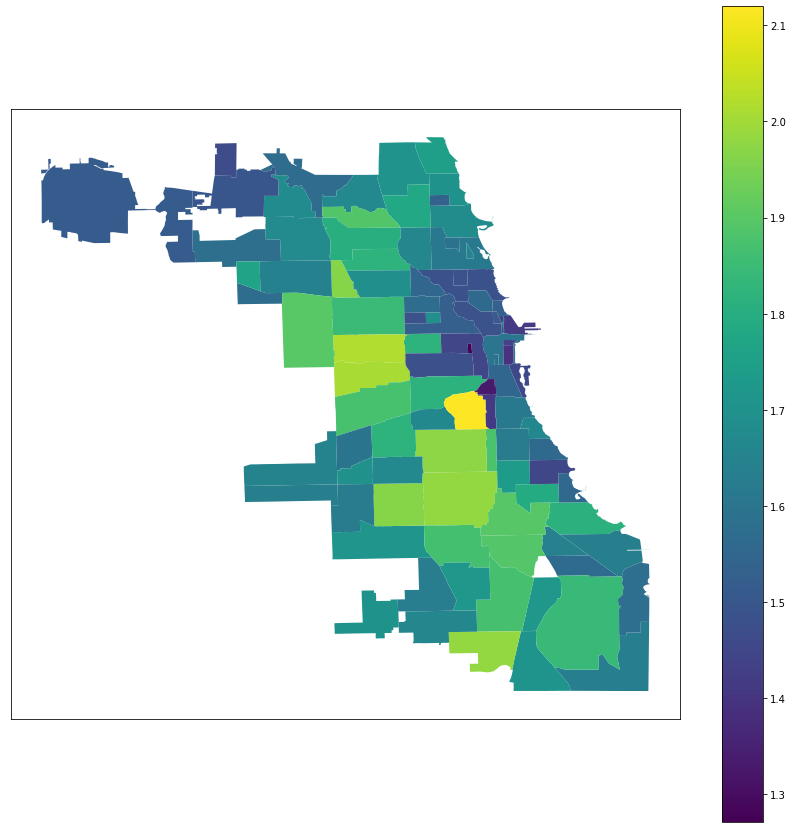

In [67]:
base = dist_risk.plot(column='mean',legend=True,figsize=(15, 15)) #按个数多少叠加底色
plt.gca().xaxis.set_major_locator(plt.NullLocator()) #去掉x轴刻度
plt.gca().yaxis.set_major_locator(plt.NullLocator()) #去年y轴刻度
# plt.savefig('./map3.png',dpi=400) #保存图片

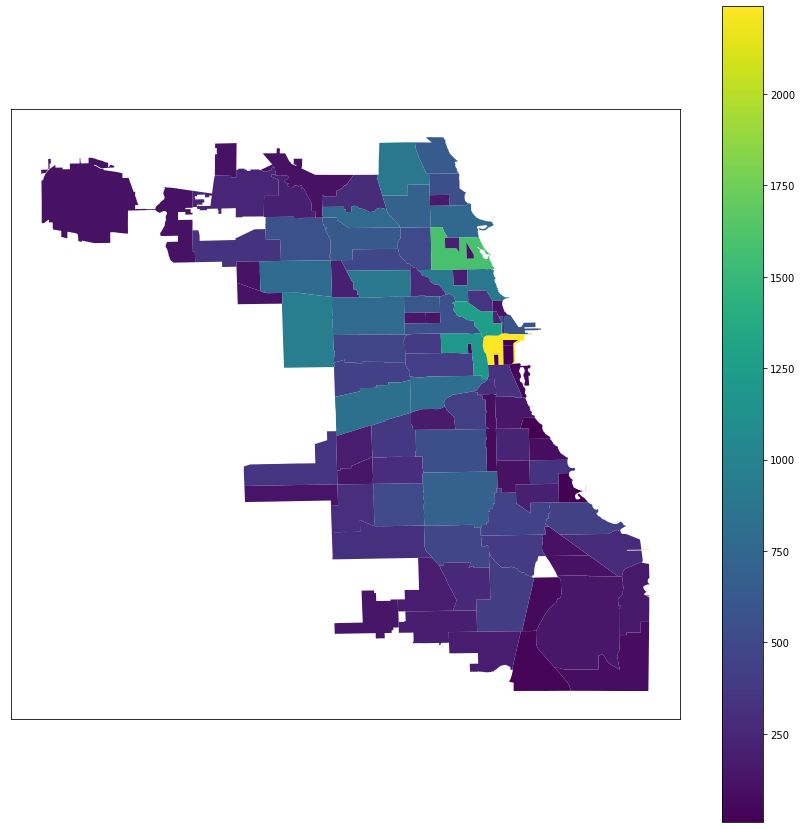

In [68]:
# plot the number that 
base = dist_risk.plot(column='count',legend=True,figsize=(15, 15)) #按个数多少叠加底色
plt.gca().xaxis.set_major_locator(plt.NullLocator()) #去掉x轴刻度
plt.gca().yaxis.set_major_locator(plt.NullLocator()) #去年y轴刻度
# plt.savefig('./map3.png',dpi=400) #保存图片

In [69]:
# sns.scatterplot(x='Longitude',y='Latitude',hue='Risk',data = DF, size = 125)

In [70]:
# sns.scatterplot(x='Longitude',y='Latitude',hue='Results',data = DF, size = 125)

## Average Risks of Facility Types, Results and Inspection Types

[1.185168167616247, 1.9424395218401225, 1.114793699874384, 1.0059574468085106, 1.5852981969486823]


<BarContainer object of 5 artists>

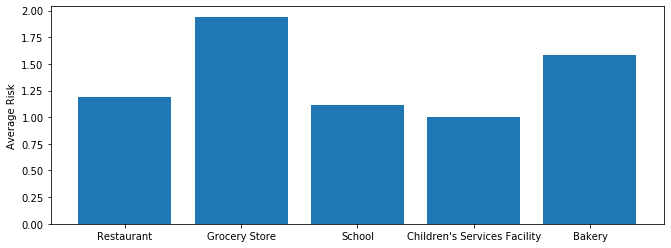

In [132]:
#Average risk for each facility type
Facilitylist = ['Restaurant','Grocery Store', 'School','Children\'s Services Facility', 'Bakery']
risksum = [0,0,0,0,0]; riskavg = [0,0,0,0,0]

for j in range(0,5):
    for i in range(1,len(DF)):
        if DF['Facility Type'][i] == Facilitylist[j]:
            if DF['Risk'][i] == 'Risk 1 (High)':
                risksum[j] = risksum[j] + 1
            if DF['Risk'][i] == 'Risk 2 (Medium)':
                risksum[j] = risksum[j] + 2
            if DF['Risk'][i] == 'Risk 3 (Low)':
                risksum[j] = risksum[j] + 3
    riskavg[j] = risksum[j]/fcounts[j]
print(riskavg)

fig = plt.figure(figsize=(11,4))
plt.ylabel('Average Risk')
plt.bar(Facilitylist,riskavg)

[1.2817405911488247, 1.3600621555060397, 1.2431365103474463, 1.394859813084112]


<BarContainer object of 4 artists>

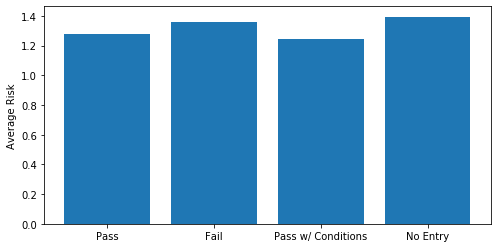

In [133]:
#Average risk for each result
Resultlist = ['Pass','Fail', 'Pass w/ Conditions','No Entry']
risksum = [0,0,0,0]; riskavg = [0,0,0,0]
for j in range(0,4):
    for i in range(1,len(DF)):
        if DF['Results'][i] == Resultlist[j]:
            if DF['Risk'][i] == 'Risk 1 (High)':
                risksum[j] = risksum[j] + 1
            if DF['Risk'][i] == 'Risk 2 (Medium)':
                risksum[j] = risksum[j] + 2
            if DF['Risk'][i] == 'Risk 3 (Low)':
                risksum[j] = risksum[j] + 3
    riskavg[j] = risksum[j]/rscounts[j]
print(riskavg)

fig = plt.figure(figsize=(8,4))
plt.ylabel('Average Risk')
plt.bar(Resultlist,riskavg)

[1.2267829328703113, 1.33119924121169, 1.5296189979123174, 1.2098782138024358, 1.3924145700337964, 1.4652977412731005, 1.562019758507135, 1.123926380368098]


<BarContainer object of 8 artists>

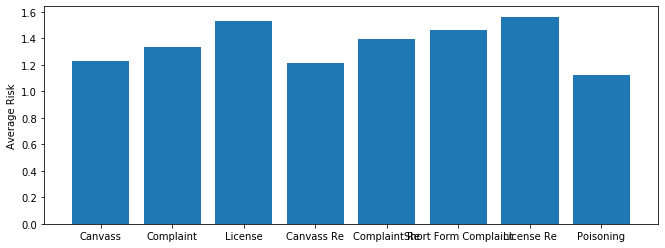

In [134]:
#Average risk for inspection types
Inspectlist = ['Canvass','Complaint', 'License','Canvass Re-Inspection','Complaint Re-Inspection','Short Form Complaint', \
              'License Re-Inspection','Suspected Food Poisoning']
risksum = [0,0,0,0,0,0,0,0]; riskavg = [0,0,0,0,0,0,0,0]
for j in range(0,8):
    for i in range(1,len(DF)):
        if DF['Inspection Type'][i] == Inspectlist[j]:
            if DF['Risk'][i] == 'Risk 1 (High)':
                risksum[j] = risksum[j] + 1
            if DF['Risk'][i] == 'Risk 2 (Medium)':
                risksum[j] = risksum[j] + 2
            if DF['Risk'][i] == 'Risk 3 (Low)':
                risksum[j] = risksum[j] + 3
    riskavg[j] = risksum[j]/ins_counts[j]
print(riskavg)

fig = plt.figure(figsize=(11,4))
plt.ylabel('Average Risk')
plt.bar(['Canvass','Complaint', 'License','Canvass Re','Complaint Re','Short Form Complaint','License Re','Poisoning'],riskavg)

## Average Pass Rate of Each Inspection Type, Year and Month 

[0.7807879886627684, 0.6576560554863952, 0.5569545929018789, 0.8968200270635994, 0.8567405182125423, 0.8256673511293634, 0.7362788144895719, 0.7411042944785277]
re-inspection improvement =  0.13224807144214323


<BarContainer object of 8 artists>

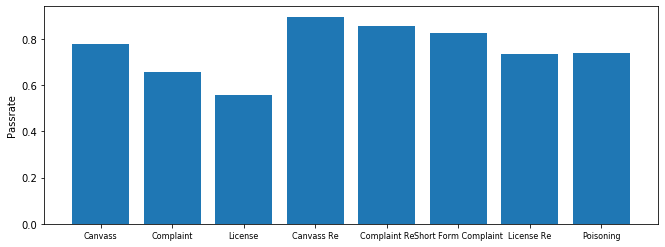

In [135]:
#passrate for inspection types
passrate = [0,0,0,0,0,0,0,0]; n_pass = passrate
for j in range(0,8):
    for i in range(1,len(DF)):
        if DF['Inspection Type'][i] == Inspectlist[j]:
            if DF['Results'][i] == 'Pass' or DF['Results'][i] == 'Pass w/ Conditions':
                n_pass[j] = n_pass[j] + 1
    passrate[j] = n_pass[j]/ins_counts[j]
print(passrate)
print('re-inspection improvement = ',(passrate[3]*ins_counts[3]+passrate[4]*ins_counts[4]+passrate[6]*ins_counts[6]) \
      /(ins_counts[3]+ins_counts[4]+ins_counts[6]) - (passrate[0]*ins_counts[0]+passrate[1]*ins_counts[1]+passrate[2]*ins_counts[2]) \
      /(ins_counts[0]+ins_counts[1]+ins_counts[2]))

fig = plt.figure(figsize=(11,4))
plt.tick_params(axis='x', labelsize=8)
plt.ylabel('Passrate')
plt.bar(['Canvass','Complaint', 'License','Canvass Re','Complaint Re','Short Form Complaint','License Re','Poisoning'],passrate)

[0.7193168818434384, 0.7275464879921705, 0.7582207980468452, 0.7881647836869661, 0.7911706349206349, 0.7767787839586029, 0.7494313210848644, 0.7407925704471726, 0.74612118873022, 0.7502641775272983]


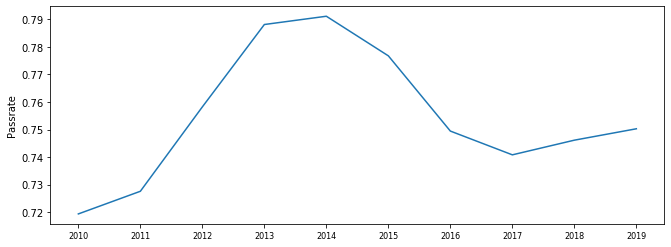

In [136]:
#passrate for each year
passrate = [0]*10; n_pass = [0]*10
yearlist = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']


for j in range(0,10):
    for i in range(1,len(DF)):
        if DF['year'][i] == yearlist[j]:
            if DF['Results'][i] == 'Pass' or DF['Results'][i] == 'Pass w/ Conditions':
                n_pass[j] = n_pass[j] + 1
    passrate[j] = n_pass[j]/ycounts[yearlist[j]]
print(passrate)

fig = plt.figure(figsize=(11,4))
plt.tick_params(axis='x', labelsize=8)
plt.ylabel('Passrate')
plt.plot(['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019'],passrate)

[0.7688556000696742, 0.7609039337859203, 0.7602127331586249, 0.7590692413347337, 0.765250222090613, 0.7554059109614665, 0.7435656584632726, 0.739096390259181, 0.73919899085462, 0.751616464280082, 0.7612787570959068, 0.775330396475771]


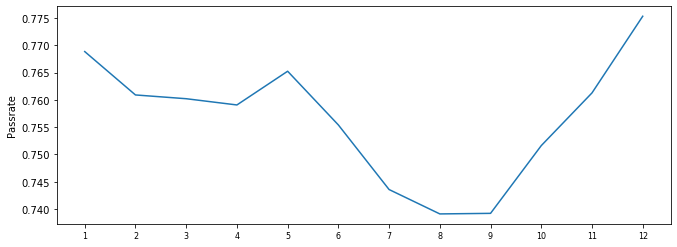

In [137]:
#passrate for each month
passrate = [0]*12; n_pass = [0]*12
monthlist = ['01','02','03','04','05','06','07','08','09','10','11','12']


for j in range(0,12):
    for i in range(1,len(DF)):
        if DF['month'][i] == monthlist[j]:
            if DF['Results'][i] == 'Pass' or DF['Results'][i] == 'Pass w/ Conditions':
                n_pass[j] = n_pass[j] + 1
    passrate[j] = n_pass[j]/mcounts[monthlist[j]]
print(passrate)

fig = plt.figure(figsize=(11,4))
plt.tick_params(axis='x', labelsize=8)
plt.ylabel('Passrate')
plt.plot(['1','2','3','4','5','6','7','8','9','10','11','12'],passrate)

## P-Value analysis of pass rate of each month

In [138]:
#Calculate the p-value of passrates of all months
monthpass = [[0] for i in range(12)]
for i in range(0,12):
    monthpass[i] = [1]*int(passrate[i]*mcounts[i]) + [0]*int((1-passrate[i])*mcounts[i])

f,p = stats.f_oneway(monthpass[0],monthpass[1],monthpass[2],monthpass[3],monthpass[4],monthpass[5], \
                    monthpass[6],monthpass[7],monthpass[8],monthpass[9],monthpass[10],monthpass[11],)
print('f=',f,'p=',p)

f= 8.044944171793057 p= 3.323312623504385e-14


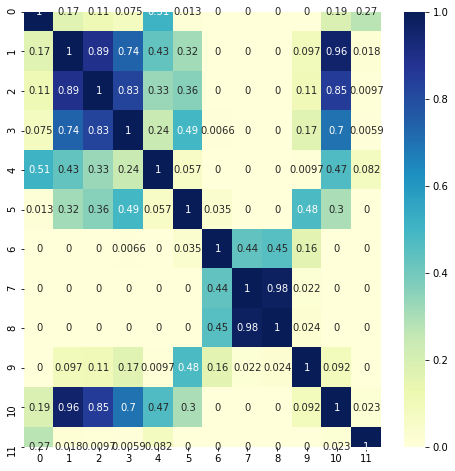

In [139]:
#plot the matrix of p-values between every two months
monthpass_p = [[0]*12 for i in range(12)]
for i in range(0,12):
    for j in range(0,12):
        f,p = stats.f_oneway(monthpass[i],monthpass[j])
        if np.isnan(p):
            p = 1.0
        if p < 0.005:
            p = 0
        monthpass_p[i][j] = p

fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(monthpass_p, cmap = 'YlGnBu', annot = True)

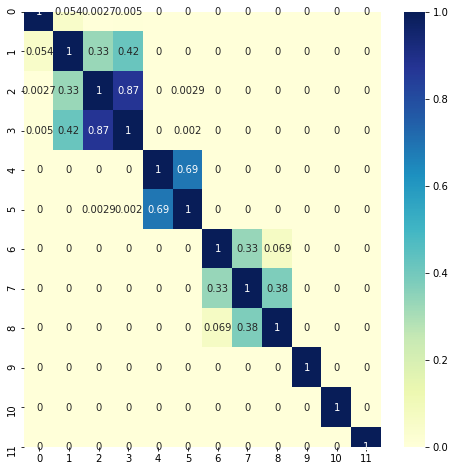

In [140]:
#Comparison
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(monthrisk_p, cmap = 'YlGnBu', annot = True)

## Risk Analysis of Keywords with High Frequencies

In [143]:
DF['name_words'] = None
DF['name_words'] = DF['AKA Name'].apply(lambda x:x.split(' '))

words_list = []
for i in range(1,len(DF)):
    words_list.append(DF['name_words'][i])

words_list = list(chain.from_iterable(words_list))
len(words_list)

416578

In [144]:
length = len(words_list)
delete_indices = []
words_list2 = []
for i in range(1,len(words_list)):
    if len(words_list[i]) <= 3:
        delete_indices.append(i)
for i in range(1,len(words_list)):
    if i not in delete_indices:
        words_list2.append(words_list[i])
len(words_list2)

328337

In [145]:
count_words = Counter(words_list2).most_common(25)
DF_words = pd.DataFrame(count_words[0:25],columns=['key word','counts'])
DF_words.head(10)

,key word,counts
0,RESTAURANT,8367
1,FOOD,5789
2,CAFE,4775
3,GRILL,3799
4,INC.,3415
5,PIZZA,3396
6,SCHOOL,3352
7,SUBWAY,3099
8,MARKET,2956
9,CHICKEN,2738


In [146]:
keywords = [0]*25
for i in range(0,25):
    keywords[i] = DF_words['key word'][i]

risksum = [0]*25; riskavg = [0]*25

for j in range(0,25):
    for i in range(1,len(DF)):
        if keywords[j] in DF['name_words'][i]:
            if DF['Risk'][i] == 'Risk 1 (High)':
                risksum[j] = risksum[j] + 1
            if DF['Risk'][i] == 'Risk 2 (Medium)':
                risksum[j] = risksum[j] + 2
            if DF['Risk'][i] == 'Risk 3 (Low)':
                risksum[j] = risksum[j] + 3
    riskavg[j] = risksum[j]/DF_words['counts'][j]
print(riskavg)

[1.0374088681725828, 1.7671445845569183, 1.1373821989528796, 1.081600421163464, 1.481112737920937, 1.2405771495877502, 1.1178400954653938, 1.0061310100032268, 1.4506089309878214, 1.570854638422206, 1.0424509411293552, 1.238762886597938, 1.4121376811594204, 1.0459446788560713, 1.118695873662761, 1.9920508744038157, 1.002212389380531, 1.0209276018099547, 1.1029579067121729, 2.1732644865174984, 1.8044890726520968, 1.962523422860712, 1.6900539707016191, 1.0, 1.6499602227525856]


<BarContainer object of 25 artists>

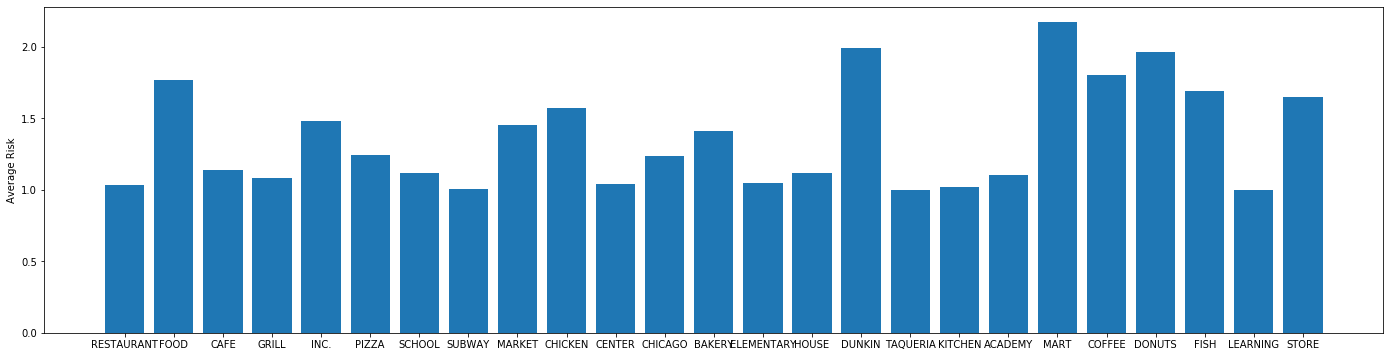

In [147]:
fig = plt.figure(figsize=(24,6))
plt.ylabel('Average Risk')
plt.bar(keywords,riskavg)

## This is the end